# Detecting Insults in Social Commentary

Because this dataset is far too small to use a neural network (which was my last approach to NLP), I'm going to experiment with some machine learning algorithms from scikit-learn to identify insults in social commentary.

When this competition ran on Kaggle 5 years ago, the best AUC ROC score was 0.84249 on the private test set (which I also have access to, and will be using as my test set). Let's see if, using all of the new tools available (i.e. GloVe vectrs), I can better this score.

## Trying different algorithms

In [216]:
% matplotlib inline

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_auc_score

from tqdm import *

Loading the data

In [105]:
glove_comments = np.load('glove_array.npy')
data = pd.read_csv('train.csv')

In [106]:
y_labels = np.asarray(data.Insult)

Making a training and validation set. 

In [107]:
glove_comments = glove_comments.reshape(len(glove_comments), -1)

In [108]:
msk = np.random.rand(len(data)) < 0.8

glove_train = glove_comments[msk]
glove_valid = glove_comments[~msk]

labels_train = y_labels[msk]
labels_valid = y_labels[~msk]

### Logistic Regression

In [323]:
log_reg = LogisticRegression(C = 10)

In [324]:
% time log_reg = log_reg.fit(glove_train, labels_train)

CPU times: user 404 ms, sys: 5.15 ms, total: 409 ms
Wall time: 421 ms


Wow that was super easy. Let's see how this does. 

Since my metric is AUC ROC, I want the probability of the comment being an insult, as opposed to just the category it is in. I'll therefore use predict_proba, and take the second value of the tuple as the chance it is an insult. 

In [325]:
predicted_y = log_reg.predict_proba(glove_valid)

In [326]:
predicted_y = [i[1] for i in predicted_y]

In [327]:
print (roc_auc_score(labels_valid, predicted_y))

0.883040168023


So this is a start! Considering how little went into this (I just took the word vectors and ran a logistic regression on it), this makes sense. However, I am interested in how this classifier was behaving, so I'm going to check the training error against the validation error as the model trains. 

In [340]:
def error_vs_m_logreg(X_train, Y_train, X_cv, Y_cv, plot=True):
    error_cv = []
    error_train = []
    logreg = LogisticRegression(C = 10)
    
    for m in tqdm(range(10, len(X_train)-1, 100)):
        logreg.fit(X_train[:m,:], Y_train[:m])
        predicted_cv = [i[1] for i in logreg.predict_proba(X_cv)]
        error_cv.append(roc_auc_score(Y_cv, predicted_cv))
        
        predicted_train = [i[1] for i in logreg.predict_proba(X_train[:m,:])]
        error_train.append(roc_auc_score(Y_train[:m], predicted_train))

    if plot: 
        fig = plt.figure(figsize = (10, 7))
        m = range(10, len(X_train)-1, 100)
        plt.plot(m, error_cv, label = 'LogReg Cross Validation Score')
        plt.plot(m, error_train, label = 'LogReg Training Score')
        plt.xlabel("Training set size")
        plt.ylabel("AUC ROC score")
        plt.legend()
        plt.show()
    
    return error_cv, error_train

100%|██████████| 32/32 [00:05<00:00,  3.05it/s]


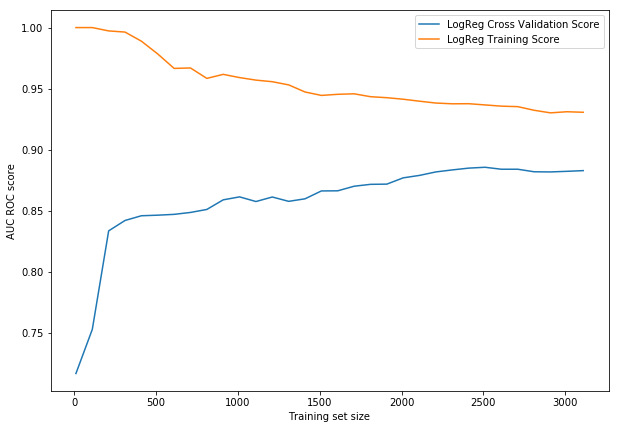

In [341]:
logreg_error_cv, logreg_error_train = error_vs_m_logreg(glove_train, labels_train, glove_valid, labels_valid)

In [307]:
logreg_error_cv[-1]

0.88090127098358373

This would have won the Kaggle competition. 

## Random Forest Classifier

In [361]:
random_forest = RandomForestClassifier(n_estimators = 100, max_depth = None, max_features = 'sqrt')

In [362]:
% time random_forest.fit(glove_train, labels_train)

CPU times: user 3.69 s, sys: 35.7 ms, total: 3.73 s
Wall time: 3.78 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Again, let's see how this does: 

In [363]:
predicted_y = [i[1] for i in random_forest.predict_proba(glove_valid)]

In [364]:
print (roc_auc_score(labels_valid, predicted_y))

0.865577656634


In [365]:
def error_vs_m_random_forest(X_train, Y_train, X_cv, Y_cv, plot=True):
    error_cv = []
    error_train = []
    random_forest = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt', max_depth = None)
    
    for m in tqdm(range(10, len(X_train)-1, 100)):
        random_forest.fit(X_train[:m,:], Y_train[:m])
        predicted_cv = [i[1] for i in random_forest.predict_proba(X_cv)]
        error_cv.append(roc_auc_score(Y_cv, predicted_cv))
        
        predicted_train = [i[1] for i in random_forest.predict_proba(X_train[:m,:])]
        error_train.append(roc_auc_score(Y_train[:m], predicted_train))

    if plot: 
        fig = plt.figure(figsize = (10, 7))
        m = range(10, len(X_train)-1, 100)
        plt.plot(m, error_cv, label = 'Random Forest Cross Validation Score')
        plt.plot(m, error_train, label = 'Random Forest Training Score')
        plt.xlabel("Training set size")
        plt.ylabel("AUC ROC score")
        plt.legend()
        plt.show()
    
    return error_cv, error_train

100%|██████████| 32/32 [01:27<00:00,  5.33s/it]


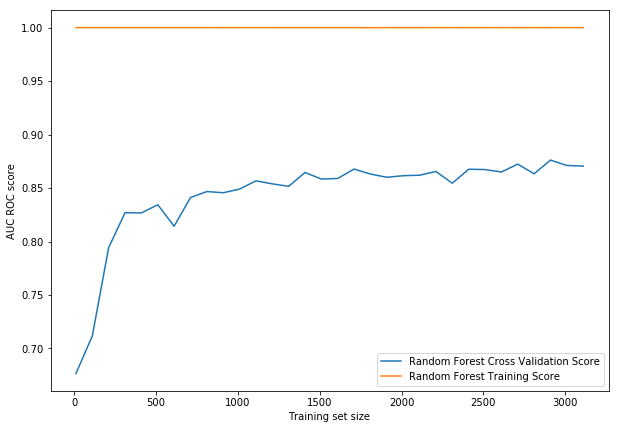

In [366]:
random_forest_error_cv, random_forest_error_train = error_vs_m_random_forest(glove_train, 
                                                                             labels_train, glove_valid, 
                                                                             labels_valid)

In [367]:
random_forest_error_cv[-1]

0.87051565178447332

This is some pretty significant overfitting, but given that there are so many hyperparameters to tune, it makes sense. 

## SVM Classifier

In [395]:
svm = SVC(C = 100, probability = True)

In [396]:
% time svm.fit(glove_train, labels_train)

CPU times: user 10.9 s, sys: 135 ms, total: 11 s
Wall time: 12 s


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=5, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [397]:
predicted_y = [i[1] for i in svm.predict_proba(glove_valid)]

In [398]:
print (roc_auc_score(labels_valid, predicted_y))

0.890862199435


In [405]:
def auc_vs_m_svm(X_train, Y_train, X_cv, Y_cv, plot=True):
    error_cv = []
    error_train = []
    svc = SVC(C = 100, probability = True)
    
    for m in tqdm(range(10, len(X_train)-1, 100)):
        svc.fit(X_train[:m,:], Y_train[:m])
        predicted_cv = [i[1] for i in svc.predict_proba(X_cv)]
        error_cv.append(roc_auc_score(Y_cv, predicted_cv))
        
        predicted_train = [i[1] for i in svc.predict_proba(X_train[:m,:])]
        error_train.append(roc_auc_score(Y_train[:m], predicted_train))

    if plot: 
        fig = plt.figure(figsize = (10, 7))
        m = range(10, len(X_train)-1, 100)
        plt.plot(m, error_cv, label = 'SVC cross validation score')
        plt.plot(m, error_train, label = 'SVC training score')
        plt.xlabel("Training set size")
        plt.ylabel("AUC ROC score")
        plt.legend()
        plt.show()
    
    return error_cv, error_train

100%|██████████| 32/32 [02:43<00:00, 12.15s/it]


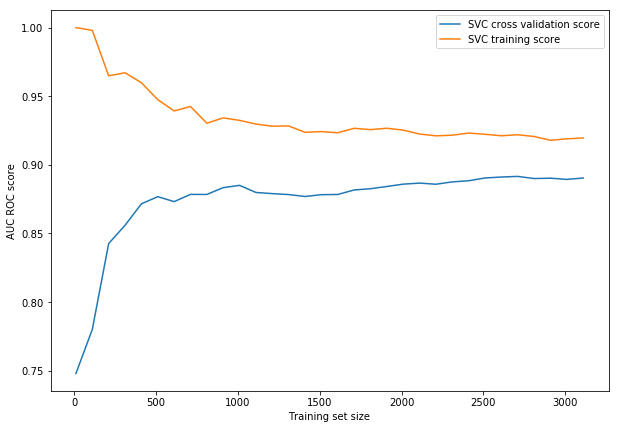

In [406]:
svc_error_cv, svc_error_train = auc_vs_m_svm(glove_train, labels_train, glove_valid, labels_valid)

In [407]:
svc_error_cv[-1]

0.89039890043704539

## Naive Bayes

In [199]:
GNB = GaussianNB()

In [211]:
% time GNB.fit(glove_train, labels_train)

CPU times: user 19.4 ms, sys: 10.3 ms, total: 29.6 ms
Wall time: 29.4 ms


GaussianNB(priors=None)

In [201]:
predicted_y = [i[1] for i in GNB.predict_proba(glove_valid)]

In [202]:
print (roc_auc_score(labels_valid, predicted_y))

0.870314888885


In [206]:
def auc_vs_m_GNB(X_train, Y_train, X_cv, Y_cv, plot=True):
    error_cv = []
    error_train = []
    GNB = GaussianNB()
    
    for m in tqdm(range(10, len(X_train)-1, 100)):
        GNB.fit(X_train[:m,:], Y_train[:m])
        predicted_cv = [i[1] for i in GNB.predict_proba(X_cv)]
        error_cv.append(roc_auc_score(Y_cv, predicted_cv))
        
        predicted_train = [i[1] for i in GNB.predict_proba(X_train[:m,:])]
        error_train.append(roc_auc_score(Y_train[:m], predicted_train))

    if plot: 
        m = range(10, len(X_train)-1, 100)
        plt.plot(m, error_cv, label = 'cv')
        plt.plot(m, error_train, label = 'train')
        plt.xlabel("Training set size")
        plt.ylabel("AUC ROC score")
        plt.legend()
        plt.show()
    
    return error_cv, error_train

100%|██████████| 32/32 [00:01<00:00, 23.62it/s]


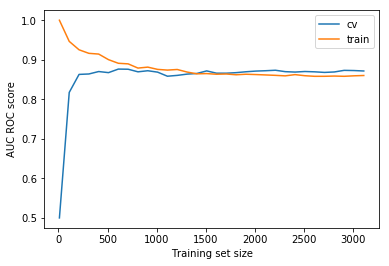

In [207]:
GNB_cv, GNB_train = auc_vs_m_GNB(glove_train, labels_train, glove_valid, labels_valid)

In [213]:
GNB_cv[-1]

0.87165459515389243

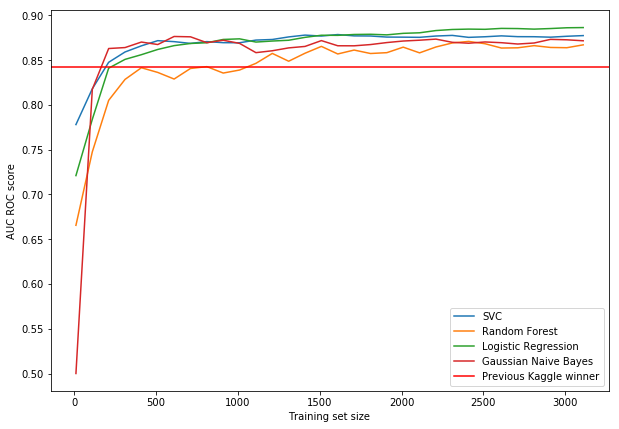

In [214]:
fig = plt.figure(figsize = (10, 7))
m = range(10, len(glove_train)-1, 100)
plt.plot(m, svc_error_cv, label = 'SVC')
plt.plot(m, random_forest_error_cv, label = 'Random Forest')
plt.plot(m, logreg_error_cv, label = 'Logistic Regression')
plt.plot(m, GNB_cv, label = 'Gaussian Naive Bayes')
plt.axhline(0.84249, color = 'r', label = 'Previous Kaggle winner')
plt.xlabel("Training set size")
plt.ylabel("AUC ROC score")
plt.legend()
plt.show()

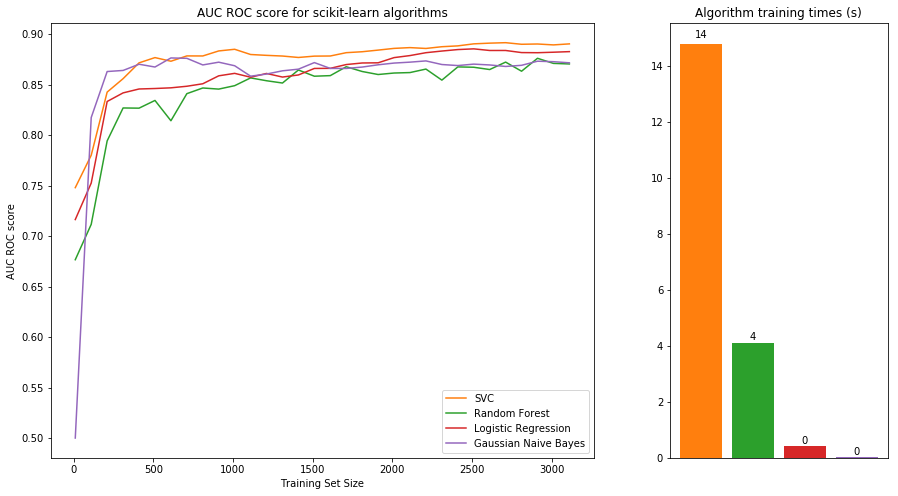

In [409]:
fig = plt.figure(figsize = (15, 8))
gs = gridspec.GridSpec(1,2, width_ratios = [5,2])
ax1 = plt.subplot(gs[0])
m = range(10, len(glove_train)-1, 100)
ax1.plot(m, svc_error_cv, label = 'SVC', color = 'C1')
ax1.plot(m, random_forest_error_cv, label = 'Random Forest', color = 'C2')
ax1.plot(m, logreg_error_cv, label = 'Logistic Regression', color = 'C3')
ax1.plot(m, GNB_cv, label = 'Gaussian Naive Bayes', color = 'C4')
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('AUC ROC score')
ax1.legend()
ax1.set_title('AUC ROC score for scikit-learn algorithms')
ax2 = plt.subplot(gs[1])
times = (14.8, 4.12,  0.421, 0.0294) 
colors = ('C1', 'C2', 'C3', 'C4')
ax2.tick_params(axis = 'x', which = 'both', top = 'off', bottom = 'off', labelbottom = 'off')
ax2.set_title('Algorithm training times (s)')
#labels = ('LogReg', 'Random Forest', 'SVC', 'Naive Bayes')
rects = ax2.bar(np.arange(len(times)), times, color = colors)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % float(height),
                ha='center', va='bottom')
autolabel(rects)
